# **MultiModal Al for Skin Condition Prediction and Treatment**


The Systems seek to employ AI models to identify SKin conditions from images the users provide and text based symptoms to identify the skin condition expecially for darker skin patients and suggesting possible treatment for the contidions.

The system employs Convolutional Neural Network to classify and identify the skin contidions for an image/ photo of the affected skin.
It employes NLP to identify the skin condition from the text based symptoms provieded by the users and finnally suggest treatment.

This Note book details the steps and methods used in achieveing the above.
it is arranged in Three parts;

1) PART 1 : CNN for Image classification

2) PART 2:  NLP for Symptoms and Treatment Processing

3) PART 3:  RL for Providing treatment based on the symptoms and disease
            classification



# **PART 1: Developing a CNN to skin Disease identification**


The CNN made of a base model for feature extraction and head model as a classifier;

**Base Model**
The base model is a pretrained network (e.g. in our case,  MobileNetV2,MobileNetV3Small, MobileNetV3Large, EfficientNetB0, EfficientNetB3,ResNet50, InceptionV3) from tf.keras.applications.These models are already trained on large datasets like ImageNet and we are starting with 7 to find the most suitable as a feature extractor.

**Head Model**
The head model is added on top of the base model to do the classifation. It consists of:
*Global Average Pooling:* Reduces the spatial dimensions of the feature maps from the base model, summarizing the learned features.
*Dense Layer:* Maps the pooled features to the number of classes in the dataset using a softmax activation.

**Proposed Achitecture Adopted:**

1) Input Image

2) Data Augmentation
        
3) Pretrained Base Model (e.g., ResNet50, MobileNetV3)

4) Global Average Pooling (Feature Summarization)

5) Dense Layer (Classifier, Softmax Activation)

6) Output Classes (Predictions)

**Intalling Dependencies and Modules**

The main Library used is Tensorflow.keras for the CNN layers and models.

In [ ]:
#@title Dependencies and Modules
!pip install tensorflow pillow requests

import os
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import tensorflow as tf
from tensorflow.keras import layers, models

# Different pretrained models for image extraction,
from tensorflow.keras.applications import (
    MobileNetV2,MobileNetV3Small, MobileNetV3Large, EfficientNetB0, EfficientNetB3,
    ResNet50, InceptionV3
)


**Dataset Used**

The data used in this project is Fitzpartick17k dataset available in kaggle. Its a csv comprising of approximately 17,000 record of image url, fitzpatick scale and labels of skin condition for each image.

In [ ]:
#@title Setting Data Path
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/Colab Notebooks/AI_ML_EXAM/fitzpatrick17k.csv"

Mounted at /content/drive


In [ ]:
#@title Loading Dataset Google drive onto this notebook
skin_data = pd.read_csv(file_path)
skin_data.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,5e82a45bc5d78bd24ae9202d194423f8,3,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...
1,fa2911a9b13b6f8af79cb700937cc14f,1,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...
2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,3,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...
3,0a94359e7eaacd7178e06b2823777789,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
4,a39ec3b1f22c08a421fa20535e037bba,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...


**FIltering the Data**

This study is focusing on the Afican skin which falls under fitzpatrick scal 4, 5 and 6. There fore not all the 17,000 images in the data set will be useful for this project. We filtered out to remain with only desired scale.
This leave us with 4934 images corresponding to the desired skin color.

In [ ]:
#@title Filtering Data for Fitzpatrick Scale 4,5 and 6 and dropping the empty urls
filtered_data = skin_data[skin_data['fitzpatrick_scale'].isin([4,5,6]) & skin_data['url'].notna()]
filtered_data[['url','label','fitzpatrick_scale']].describe()

,fitzpatrick_scale
count,4934.000000
mean,4.564856
std,0.707715
min,4.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,6.000000


In [ ]:
# Target folder under My Drive
DRIVE_ROOT = '/content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/'
base_dir = f'{DRIVE_ROOT}/skin_images'
os.makedirs(base_dir, exist_ok=True)

**Accessing Images.**

The .csv fil provides url to the public location of the images. Therefore, to make use of it, in this section, we download, resize  and save the images in their correct labels in our google drive in a folder skin_images.                                                                   This section does that and takes a count of the total number of images that have successfully been downloaded.

In [ ]:
#@title Downloading and Resizing Images
from pathlib import Path
# Target folder under My Drive
DRIVE_ROOT = '/content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/'
base_dir = f'{DRIVE_ROOT}/skin_images'
os.makedirs(base_dir, exist_ok=True)

# Remove duplicates from the dataset
filtered_data = filtered_data.drop_duplicates(subset=['url'])

# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36"
}

# Initialize counters
total_images_downloaded = 0
failed_urls = []

# Download, resize, and save images
for idx, row in filtered_data.iterrows():
    lbl, url = row['label'], row['url']
    outdir = os.path.join(base_dir, lbl)
    os.makedirs(outdir, exist_ok=True)
    try:
        # Use headers in the request
        resp = requests.get(url, headers=headers, timeout=10)  # Add headers
        resp.raise_for_status()

        # Process and save the image
        img = Image.open(BytesIO(resp.content)).convert('RGB')
        img = img.resize((224, 224))

        # Ensure unique filenames
        unique_filename = f"{idx}_{hash(url)}.jpg"
        img.save(os.path.join(outdir, unique_filename))
        total_images_downloaded += 1
    except Exception as e:
        failed_urls.append((url, str(e)))  # Log failed URLs

# Verify and count total files
file_count = sum(1 for _ in Path(base_dir).rglob('*.jpg'))

# Display results
print(f"Total images downloaded and stored: {total_images_downloaded}")
print(f"Total image files found in folder and subfolders: {file_count}")
print(f"Failed URLs: {len(failed_urls)}")

# Optional: Save failed URLs for review
failed_urls_path = f'{DRIVE_ROOT}/failed_urls.txt'
with open(failed_urls_path, 'w') as f:
    for url, error in failed_urls:
        f.write(f"{url}\t{error}\n")
print(f"Failed URLs logged to: {failed_urls_path}")



Total images downloaded and stored: 4926
Total image files found in folder and subfolders: 4926
Failed URLs: 8
Failed URLs logged to: /content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM//failed_urls.txt


**Data Augmentation**

Generally, there is limited data available for skin conditions affecting african skin. Using data augumentation, we  leverage the 4934 images to create variying copies for training the model. We employ both on the** on-the-fly Data AUgmentation** and **Manual data Augmentation** to make 100,000 images.

In [ ]:
#@title Buidling tesnor flow Dataset with Data Augmentation(On-the-fly)
img_size, batch = 224, 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir, validation_split=0.2, subset='training',
    seed=42, image_size=(img_size, img_size), batch_size=batch
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir, validation_split=0.2, subset='validation',
    seed=42, image_size=(img_size, img_size), batch_size=batch
)

class_names = train_dataset.class_names
num_classes = len(class_names)

#train_dataset = train_dataset.take(100)
#val_dataset = val_dataset.take(20)



AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset   = val_dataset.prefetch(AUTOTUNE)

# Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.2)
])

print("Class names:", class_names)
print("Class names:", num_classes)

Found 4926 files belonging to 114 classes.
Using 3941 files for training.
Found 4926 files belonging to 114 classes.
Using 985 files for validation.
Class names: ['acanthosis nigricans', 'acne', 'acne vulgaris', 'acquired autoimmune bullous diseaseherpes gestationis', 'acrodermatitis enteropathica', 'actinic keratosis', 'allergic contact dermatitis', 'aplasia cutis', 'basal cell carcinoma', 'basal cell carcinoma morpheiform', 'becker nevus', 'behcets disease', 'calcinosis cutis', 'cheilitis', 'congenital nevus', 'dariers disease', 'dermatofibroma', 'dermatomyositis', 'disseminated actinic porokeratosis', 'drug eruption', 'drug induced pigmentary changes', 'dyshidrotic eczema', 'eczema', 'ehlers danlos syndrome', 'epidermal nevus', 'epidermolysis bullosa', 'erythema annulare centrifigum', 'erythema elevatum diutinum', 'erythema multiforme', 'erythema nodosum', 'factitial dermatitis', 'fixed eruptions', 'folliculitis', 'fordyce spots', 'granuloma annulare', 'granuloma pyogenic', 'hailey 

**Model Building**
The model is made of base and head models. We employ early stopping whenever the val_loss has platued in two consecutive epochs
We applied the following;

**EarlyStopping:** To stop training when the validation performance stops improving, saving computation time and preventing overfitting. Originally used

**ReduceLROnPlateau:** To dynamically reduce the learning rate if the validation loss plateaus, helping the model converge better.

In [ ]:
#@title Building the Models

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    )
]


def build_and_train(Base, name, epochs):
    # Load the base model with pretrained weights
    base = Base(weights='imagenet', include_top=False,
                input_shape=(img_size, img_size, 3))
    base.trainable = False  # Keep pretrained layers frozen initially

    # Build the full model
    inputs = layers.Input((img_size, img_size, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.imagenet_utils.preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name=name)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model with callbacks
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks,  # Apply EarlyStopping and ReduceLROnPlateau
        verbose=2
    )
    val_acc = history.history['val_accuracy'][-1]
    return name, val_acc


**Training and comparing at 5 epochs and Sample data**

In [ ]:
#@title Training and Comparing five Architectures
choices = [
    (MobileNetV2, 'MobileNetV2'),
    (MobileNetV3Small, 'MobileNetV3Small'),
    (MobileNetV3Large, 'MobileNetV3Large'),
    (EfficientNetB0, 'EfficientNetB0'),
    (EfficientNetB3, 'EfficientNetB3'),
    (ResNet50,    'ResNet50'),
    (InceptionV3, 'InceptionV3'),
]

results = []
for cls, nm in choices:
    print(f"\n▶ Training {nm} …")
    results.append(build_and_train(cls, nm, 5))



▶ Training MobileNetV2 …
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
124/124 - 27s - 218ms/step - accuracy: 0.0525 - loss: 4.5740 - val_accuracy: 0.0701 - val_loss: 4.3987 - learning_rate: 1.0000e-03
Epoch 2/5
124/124 - 15s - 124ms/step - accuracy: 0.0898 - loss: 4.1233 - val_accuracy: 0.0893 - val_loss: 4.2416 - learning_rate: 1.0000e-03
Epoch 3/5
124/124 - 19s - 151ms/step - accuracy: 0.1071 - loss: 3.9643 - val_accuracy: 0.1086 - val_loss: 4.2193 - learning_rate: 1.0000e-03
Epoch 4/5
124/124 - 13s - 109ms/step - accuracy: 0.1203 - loss: 3.8412 - val_accuracy: 0.1046 - val_loss: 4.1568 - learning_rate: 1.0000e-03
Epoch 5/5
124/124 - 20s - 165ms/step - accuracy: 0.1434 - loss: 3.7327 - val_accuracy: 0.0985 - val_loss: 4.1683 - learning_rate: 1.0000e-03

▶ Training MobileNetV3Small …
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
124/124 - 22s - 177ms/step - accuracy: 0.0716 - loss: 4.3132 - val_accuracy: 0.1137 - val_loss: 4.0310 - learning_rate: 1.0000e-03

**MobileNet Variants:**

**MobileNetV2** and **MobileNetV3Small** performed reasonably well with val_accuracy ~28–35%. **MobileNetV3Large** outperformed both with a validation accuracy of ~36% after 5 epochs. These models are lightweight and train faster than others.

**EfficientNet Variants:**

**EfficientNetB0** showed a gradual improvement, reaching ~32% validation accuracy after 5 epochs. **EfficientNetB3**, due to its larger size, trained slower and achieved ~21% validation accuracy, possibly needing more epochs to converge.

**ResNet50:** This model achieved the highest validation accuracy of ~48% after 5 epochs, demonstrating its robustness. However, training ResNet50 is computationally expensive and takes significantly more time.

**InceptionV3:** Struggled to converge, with a validation accuracy of only ~7.5% and high loss values. This could be due to its complexity or a mismatch in its architecture with the dataset's characteristics.

In [ ]:
#@title Display Results
pd.DataFrame(results, columns=['Model','Val_Accuracy'])


**Refocus on the top two performing Models**

RestNet50 and MobileNetV3Large performed best in the test with sample data. The next stage focuses on using the whole data while increasing the epoch to 10.

In [ ]:
#@title top two models, increasing epochs 25
top_choices = [
    (ResNet50, 'ResNet50'),
    (MobileNetV3Large, 'MobileNetV3Large')
]

top_results = []
for cls, nm in top_choices:
    print(f"\n Retraining {nm} for 25 epochs …")
    name, acc = build_and_train(cls, nm, epochs=25)
    top_results.append((name, acc))

# Display results for top models
pd.DataFrame(top_results, columns=['Model', 'Val_Accuracy']).sort_values('Val_Accuracy', ascending=False)



 Retraining ResNet50 for 25 epochs …
Epoch 1/25
124/124 - 620s - 5s/step - accuracy: 0.1385 - loss: 4.0961 - val_accuracy: 0.2223 - val_loss: 3.6630 - learning_rate: 1.0000e-03
Epoch 2/25
124/124 - 607s - 5s/step - accuracy: 0.2943 - loss: 2.9373 - val_accuracy: 0.2670 - val_loss: 3.3949 - learning_rate: 1.0000e-03
Epoch 3/25
124/124 - 622s - 5s/step - accuracy: 0.3849 - loss: 2.5046 - val_accuracy: 0.2914 - val_loss: 3.3109 - learning_rate: 1.0000e-03
Epoch 4/25
124/124 - 623s - 5s/step - accuracy: 0.4466 - loss: 2.1933 - val_accuracy: 0.2975 - val_loss: 3.2177 - learning_rate: 1.0000e-03
Epoch 5/25
124/124 - 621s - 5s/step - accuracy: 0.4945 - loss: 1.9854 - val_accuracy: 0.3117 - val_loss: 3.1859 - learning_rate: 1.0000e-03
Epoch 6/25
124/124 - 624s - 5s/step - accuracy: 0.5242 - loss: 1.8203 - val_accuracy: 0.3452 - val_loss: 3.1342 - learning_rate: 1.0000e-03
Epoch 7/25
124/124 - 620s - 5s/step - accuracy: 0.5549 - loss: 1.6996 - val_accuracy: 0.3360 - val_loss: 3.0955 - learning

,Model,Val_Accuracy
0,ResNet50,0.405076
1,MobileNetV3Large,0.291371


In [ ]:
#@title Saving the models
resnet50_model_path = '/content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/ResNet50_model.h5'
mobilenetv3_model_path = '/content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/MobileNetV3Large_model.h5'

# Instantiate the models before saving
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Instantiate ResNet50 model
mobilenetv3large_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Instantiate MobileNetV3Large model


# Save the models
resnet50_model.save(resnet50_model_path) # Save the ResNet50 model instance
mobilenetv3large_model.save(mobilenetv3_model_path) # Save the MobileNetV3Large model instance

print(f"ResNet50 model saved to: {resnet50_model_path}")
print(f"MobileNetV3Large model saved to: {mobilenetv3_model_path}")

ResNet50 model saved to: /content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/ResNet50_model.h5
MobileNetV3Large model saved to: /content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/MobileNetV3Large_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


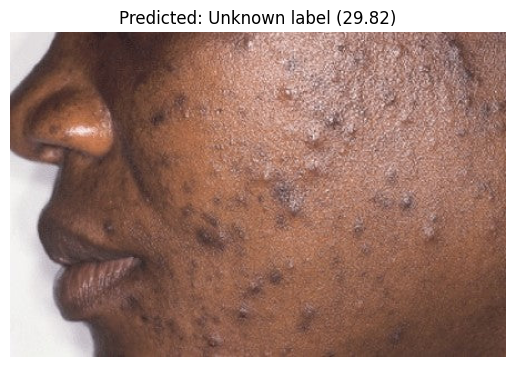

In [ ]:
#@title Testing model on real world data
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load the trained model
model_path = '/content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/ResNet50_model.h5'
try:
    model = load_model(model_path, compile=False)  # Prevent automatic compilation
    # Compile the model manually
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
except Exception as e:
    print(f"Error loading or compiling model: {e}")
    exit()

image_path = '/content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/test_image2.jpg'

label_mapping = {i: class_name for i, class_name in enumerate(class_names)}
def classify_image(image_path):

    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make a prediction
    predictions = model.predict(img_array)

    # Get predicted class and confidence
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Map class index to label
    label = label_mapping.get(predicted_class, "Unknown label")
    return label, confidence




# Test the application
label, confidence = classify_image(image_path)

# Display the result
plt.imshow(load_img(image_path))
plt.axis('off')
plt.title(f"Predicted: {label} ({confidence:.2f})")
plt.show()

# **Fune Tuning to improve prediction accuracy.**

The model performs poorly there calling for improvements

In fine tuning, we empploy Data augmentation and carry out Randomflip,random roatate, randomsoom, rnadom brightness and random contrast to generate more images that would help improve validation accuracy.

We employ the following as part of call back:

In addition to earlystopping and ReducedOnplataeu we applied

ModelCheckpoint: To save the best-performing model based on validation loss.

We use the following in the classification head as used before:

Global Average Pooling: which reduces the spatial dimensions of the base model's output into a single vector per feature map. it makes the model robust to spatial variations and reduces the number of trainable parameters.
Dense Layer: A fully connected layer with 128 units.
Activation: ReLU (Rectified Linear Unit). ReLU helps hidden layers learn rich, non-linear feature representations, making the network more expressive and capable of capturing intricate patterns in the data
Regularization:  𝐿2 penalty with a factor of 0.02 to prevent overfitting.
Dropout: Probability: 50%. Randomly drops out neurons during training to further prevent overfitting and improve generalization.
Output Layer:Fully connected layer with num_classes units (equal to the number of classes in the dataset).
Activation: Softmax, which converts logits into class probabilities. Softmax translates the network's outputs into probabilities for classification tasks, making it easier to evaluate and interpret the model's predictions.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import datetime
import os
import pickle

output_dir = '/content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM'
os.makedirs(output_dir, exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(output_dir, 'best_model.keras'),  # Save in TensorFlow SavedModel format
        monitor='val_loss',
        save_best_only=True,
        # save_format='tf',  # Remove this line as save_format is deprecated
        verbose=1
    ),
    TensorBoard(
        log_dir=os.path.join(output_dir, 'logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
        histogram_freq=1
    )
]


def improved_build_and_train(Base, name, epochs=50, learning_rate=1e-4, unfreeze_layers=0):
    base = Base(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = unfreeze_layers > 0

    if base.trainable:
        for layer in base.layers[:-unfreeze_layers]:
            layer.trainable = False

    # Define data augmentation pipeline
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.3),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2)
    ])

    # Build the model
    inputs = layers.Input((224, 224, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.imagenet_utils.preprocess_input(x)
    x = base(x, training=base.trainable)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name=name)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks,
        verbose=2
    )

    # Save the model in TensorFlow format
    model.save(os.path.join(output_dir, f'{name}_final.keras'), save_format='tf')
    return model, history



**Traing the two models after with an improved model build and training**

In [ ]:
# Train ResNet50 with Unfreezing
print("\n Fine-tuning ResNet50 (Unfreeze Last 50 Layers)...")
resnet50_improved, resnet50_improved_history = improved_build_and_train(
    Base=ResNet50,
    name="ResNet50_Improved",
    epochs=30,
    learning_rate=1e-4,
    unfreeze_layers=50
)

# Train MobileNetV3Large without Unfreezing
print("\n Fine-tuning MobileNetV3Large...")
mobilenetv3_improved, mobilenetv3_improved_history = improved_build_and_train(
    Base=MobileNetV3Large,
    name="MobileNetV3Large_Improved",
    epochs=30,
    learning_rate=1e-4,
    unfreeze_layers=0
)


 Fine-tuning ResNet50 (Unfreeze Last 50 Layers)...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/30

Epoch 1: val_loss improved from inf to 8.39773, saving model to /content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/best_model.keras
124/124 - 1137s - 9s/step - accuracy: 0.0431 - loss: 9.1802 - val_accuracy: 0.1137 - val_loss: 8.3977 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 8.39773 to 7.41757, saving model to /content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/best_model.keras
124/124 - 87s - 703ms/step - accuracy: 0.1289 - loss: 8.0512 - val_accuracy: 0.2071 - val_loss: 7.4176 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 7.41757 to 6.68842, saving model to /content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/best_model.keras
124/124 - 84s - 676ms/step - accuracy: 0.2144 - loss: 7.1363 - val_accuracy: 0.2802 - val_loss: 6.6884 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 6.68842 to 6.17922, savi


 Fine-tuning MobileNetV3Large...
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30

Epoch 1: val_loss did not improve from 2.75414
124/124 - 31s - 250ms/step - accuracy: 0.0150 - loss: 9.1553 - val_accuracy: 0.0457 - val_loss: 8.4731 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss did not improve from 2.75414
124/124 - 20s - 158ms/step - accuracy: 0.0343 - loss: 8.3001 - val_accuracy: 0.0711 - val_loss: 7.8357 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss did not improve from 2.75414
124/124 - 20s - 163ms/step - accuracy: 0.0406 - loss: 7.7180 - val_accuracy: 0.0853 - val_loss: 7.2994 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss did not improve from 2.75414
124/124 - 21s - 167ms/step - accuracy: 0.0487 - loss: 7.2334 - val_accuracy: 0.0904 - val_loss: 6.8501 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_loss did not improve from 2.75414
124/124 - 18s - 146ms/step - accuracy: 0.0573 - loss: 6.8200 - val_accuracy: 0.1005 - val_loss: 

**At 7 epochs, the fine tuning appears to produce better training and validation accuracy so far, showing less overfitting compared to the previous model bilding and training. To avoid training interruptions, the best model is saved at each epoch.**

In [ ]:
#@title Saving the models
resnet50_model_path2 = '/content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/ResNet50_model2.h5'

# Instantiate the models before saving
resnet50_model2 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Instantiate ResNet50 model

# Save the models
resnet50_model2.save(resnet50_model_path2) # Save the ResNet50 model instance

print(f"ResNet50 model2 saved to: {resnet50_model_path2}")


ResNet50 model2 saved to: /content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/ResNet50_model2.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


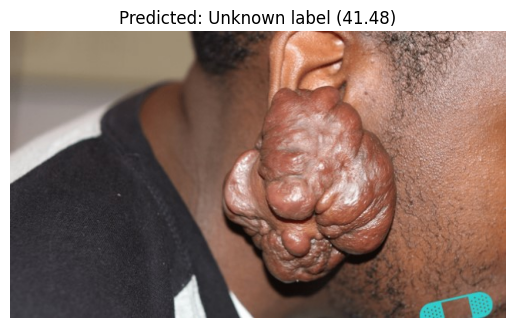

In [ ]:
#@title Testing model on real world data
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load the trained model
model_path = '/content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/ResNet50_model2.h5'
try:
    model = load_model(model_path, compile=False)  # Prevent automatic compilation
    # Compile the model manually
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
except Exception as e:
    print(f"Error loading or compiling model: {e}")
    exit()

image_path = '/content/drive/MyDrive/Colab Notebooks/AI_ML_EXAM/test_image.jpg'

label_mapping = {i: class_name for i, class_name in enumerate(class_names)}
def classify_image(image_path):

    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make a prediction
    predictions = model.predict(img_array)

    # Get predicted class and confidence
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Map class index to label
    label = label_mapping.get(predicted_class, "Unknown label")
    return label, confidence




# Test the application
label, confidence = classify_image(image_path)

# Display the result
plt.imshow(load_img(image_path))
plt.axis('off')
plt.title(f"Predicted: {label} ({confidence:.2f})")
plt.show()

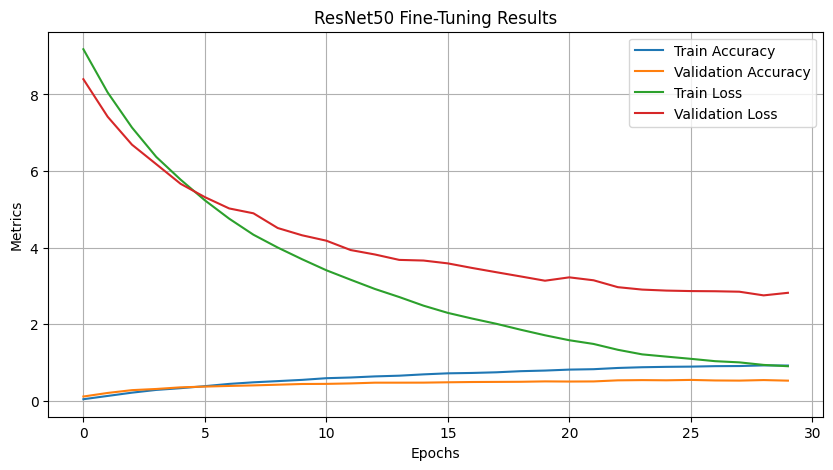

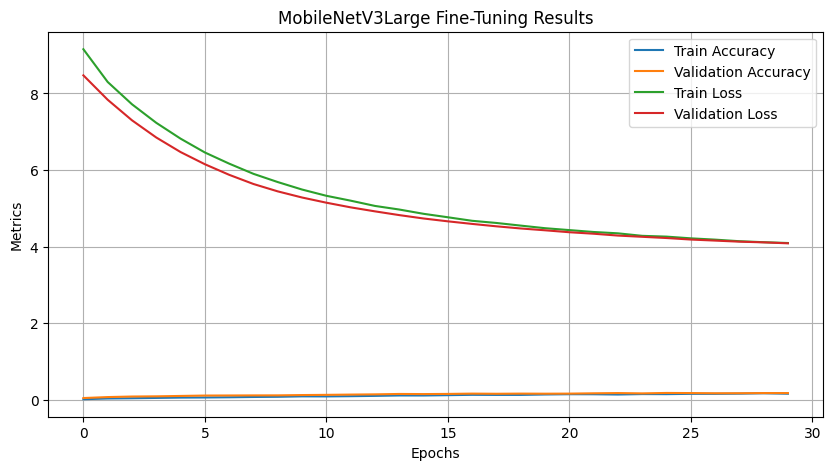

In [ ]:
#@title Plotting Results
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid()
    plt.show()

# Plot ResNet50 Results
plot_history(resnet50_improved_history, "ResNet50 Fine-Tuning Results")

# Plot MobileNetV3Large Results
plot_history(mobilenetv3_improved_history, "MobileNetV3Large Fine-Tuning Results")
